In [1]:
import pandas as pd
import numpy as np
import glob, os, cv2
from matplotlib import pyplot as plt

In [2]:
from sklearn import preprocessing
from sklearn import model_selection
from sklearn import linear_model
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report

In [3]:
from keras import backend as K
from keras import regularizers
from keras.utils.np_utils import to_categorical
from keras.models import Sequential,Model,load_model
from keras.layers import Dense,Input,Flatten,Dropout,Concatenate,GlobalAveragePooling2D,Lambda,ZeroPadding2D,BatchNormalization,MaxPool2D
from keras.layers import SeparableConv2D,BatchNormalization,MaxPooling2D,Conv2D,AveragePooling2D,ReLU
from keras.applications.resnet_v2 import ResNet152V2, preprocess_input
from keras.callbacks import EarlyStopping,CSVLogger,ReduceLROnPlateau

2022-09-01 18:58:50.726336: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/rtrk/.local/lib/python3.8/site-packages/cv2/../../lib64:/opt/ros/noetic/lib
2022-09-01 18:58:50.726354: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [4]:
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam, RMSprop

In [5]:
RANDOM_STATE = 54
DIRECTORY = "UTKFace/"
NUM_OF_EPOCHES = 30
CLASSES = [0,1,2,3,4,5,6]

In [6]:
# first number before _ in filenames of images are person's age (in 39_1_20170116174525125.jpg.chip.jpg 39 is the age)
# parsing and returning age for each image in directory
def parse_filepath(filepath):
    try:
        path, filename = os.path.split(filepath)
        filename, ext = os.path.splitext(filename)
        age, gender, race, _ = filename.split("_")
        return int(age)
    except Exception as e:
        print(filepath)
        return None

In [7]:
files = glob.glob(os.path.join(DIRECTORY, "*.jpg"))
data = list(map(parse_filepath, files))

UTKFace/39_1_20170116174525125.jpg.chip.jpg
UTKFace/61_1_20170109150557335.jpg.chip.jpg
UTKFace/61_1_20170109142408075.jpg.chip.jpg


In [8]:
# making data frame with images and ages
df = pd.DataFrame(data)
df['file'] = files
df.columns = ['age', 'file']
df = df.sort_values(by=['age'])
df = df.dropna()
df.head()

,age,file
2158,1.0,UTKFace/1_1_2_20161219210955701.jpg.chip.jpg
20345,1.0,UTKFace/1_0_0_20161219200338012.jpg.chip.jpg
21263,1.0,UTKFace/1_1_0_20170109192728714.jpg.chip.jpg
16335,1.0,UTKFace/1_0_1_20170110213808936.jpg.chip.jpg
15811,1.0,UTKFace/1_0_3_20161219225723376.jpg.chip.jpg


In [9]:
df.shape

(23705, 2)

In [10]:
# grouping age in 7 intervals
def class_label(age):
    if 1 <= age <= 2:
        return 0
    elif 3 <= age <= 9:
        return 1
    elif 10 <= age <= 20:
        return 2
    elif 21 <= age <= 27:
        return 3
    elif 28 <= age <= 45:
        return 4
    elif 46 <= age <= 65:
        return 5
    else:
        return 6

In [11]:
df['target'] = df['age'].map(class_label)

In [12]:
k = np.bincount(df['target'])
k

array([1605, 1457, 1815, 5572, 7645, 3912, 1699])

In [13]:
# data is not balanced, so we are undersampling by taking 1600 random instances of the most numerous classes
class_3 = df[4878:10449].sample(frac=1)[:1600]
class_4 = df[10451:18094].sample(frac=1)[:1600]
class_5 = df[18095:22006].sample(frac=1)[:1600]

In [14]:
# deleting all instances of the most numerous classes
df = df.drop(df[df['target']==3].index)
df = df.drop(df[df['target']==4].index)
df = df.drop(df[df['target']==5].index)

In [15]:
# adding 1600 of each
df = pd.concat([df,class_3])
df = pd.concat([df,class_4])
df = pd.concat([df,class_5])

In [16]:
k = np.bincount(df['target'])
k

array([1605, 1457, 1815, 1600, 1600, 1600, 1699])

In [17]:
df.shape

(11376, 3)

In [18]:
X_files = df['file']
y = df['target']
X = []

In [19]:
df.head()

,age,file,target
2158,1.0,UTKFace/1_1_2_20161219210955701.jpg.chip.jpg,0
20345,1.0,UTKFace/1_0_0_20161219200338012.jpg.chip.jpg,0
21263,1.0,UTKFace/1_1_0_20170109192728714.jpg.chip.jpg,0
16335,1.0,UTKFace/1_0_1_20170110213808936.jpg.chip.jpg,0
15811,1.0,UTKFace/1_0_3_20161219225723376.jpg.chip.jpg,0


In [20]:
for img in X_files:
    image = cv2.imread(img, cv2.IMREAD_COLOR)
    X.append(np.array(image))

In [21]:
label_encoder= LabelEncoder()
Y = label_encoder.fit_transform(y)
Y = to_categorical(Y,7)

In [22]:
X = np.array(X)
X = preprocess_input(X)

In [23]:
X.shape,Y.shape

((11376, 200, 200, 3), (11376, 7))

In [24]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, Y, test_size=0.33, stratify=Y, random_state=RANDOM_STATE)

In [25]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((7621, 200, 200, 3), (3755, 200, 200, 3), (7621, 7), (3755, 7))

In [ ]:
y_train_cls = np.argmax(y_train, axis = 1)
plt.figure(figsize=(55,30))
plt.title('Train class distribution', fontsize=65)
plt.xlabel('Classes', fontsize=50)
plt.ylabel('Number of images', fontsize=50)
plt.xticks(fontsize= 20)
plt.yticks(fontsize= 40)
plt.bar(CLASSES,np.bincount(y_train_cls))
plt.show()

In [27]:
reduce = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=0.0005,
    verbose=1
)

stop = EarlyStopping(
    monitor="val_loss",
    patience=4,
    verbose=1,
    restore_best_weights=False,
)

callbacks = [reduce, stop]

In [28]:
model = Sequential([

Conv2D(filters=16, kernel_size=(5,5), strides=(5,5), activation='relu', input_shape=(200, 200, 3)),
Conv2D(filters=32, kernel_size=(3,3), strides=(5,5), activation='relu'),
Conv2D(filters=64, kernel_size=(3,3), strides=(5,5), activation='relu'),
MaxPool2D(pool_size=(3,3)),
Conv2D(filters=128, kernel_size=(3,3), strides=(5,5), activation='relu'),
MaxPool2D(pool_size=(3,3)),
Conv2D(filters=128, kernel_size=(3,3), strides=(5,5), activation='relu'),
MaxPool2D(pool_size=(3,3)),
GlobalAveragePooling2D(),
Dense(1024, activation='relu'),
Dropout(0.3),
Dense(7, activation='softmax')
          ])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 196, 196, 16)      1216      
                                                                 
 conv2d_1 (Conv2D)           (None, 194, 194, 32)      4640      
                                                                 
 conv2d_2 (Conv2D)           (None, 192, 192, 64)      18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 64)       0         
 )                                                               
                                                                 
 conv2d_3 (Conv2D)           (None, 62, 62, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 20, 20, 128)      0         
 2D)                                                    

2022-09-01 18:59:04.430964: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-01 18:59:04.432281: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/rtrk/.local/lib/python3.8/site-packages/cv2/../../lib64:/opt/ros/noetic/lib
2022-09-01 18:59:04.432347: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/rtrk/.local/lib/python3.8/site-packages/cv2/../../lib64:/opt/ros/noetic/lib
2022-09-01 18:59:04.432406: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library '

In [29]:
model.compile(loss=CategoricalCrossentropy(), optimizer=RMSprop(learning_rate=0.005), metrics=['accuracy'])

history = model.fit(X_train, y_train,
                    epochs = NUM_OF_EPOCHES,
                    verbose = 1,
                    validation_split=0.2,
                    callbacks=callbacks
                    )

2022-09-01 18:59:04.506514: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 2926080000 exceeds 10% of free system memory.


Epoch 1/30


2022-09-01 18:59:07.964237: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 78675968 exceeds 10% of free system memory.
2022-09-01 18:59:08.047617: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 154157056 exceeds 10% of free system memory.
2022-09-01 18:59:08.084113: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 301989888 exceeds 10% of free system memory.
2022-09-01 18:59:08.188830: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 33554432 exceeds 10% of free system memory.


191/191 [==============================] - 282s 1s/step - loss: 2.6406 - accuracy: 0.1588 - val_loss: 2.1775 - val_accuracy: 0.1331 - lr: 0.0050
Epoch 2/30
191/191 [==============================] - 275s 1s/step - loss: 1.9875 - accuracy: 0.1539 - val_loss: 1.9346 - val_accuracy: 0.1784 - lr: 0.0050
Epoch 3/30
191/191 [==============================] - 279s 1s/step - loss: 1.9081 - accuracy: 0.1946 - val_loss: 1.8109 - val_accuracy: 0.2636 - lr: 0.0050
Epoch 4/30
191/191 [==============================] - 275s 1s/step - loss: 1.7991 - accuracy: 0.2418 - val_loss: 1.5964 - val_accuracy: 0.3161 - lr: 0.0050
Epoch 5/30
191/191 [==============================] - 274s 1s/step - loss: 1.6585 - accuracy: 0.3268 - val_loss: 1.4419 - val_accuracy: 0.3784 - lr: 0.0050
Epoch 6/30
191/191 [==============================] - 274s 1s/step - loss: 1.5379 - accuracy: 0.3704 - val_loss: 1.7226 - val_accuracy: 0.3482 - lr: 0.0050
Epoch 7/30
191/191 [==============================] - 274s 1s/step - loss: 

In [33]:
def plot_acc_loss(history, num_of_epochs):
    plt.figure(figsize=(10, 4))

    plt.subplot(1, 2, 1)
    plt.title('Loss')
    plt.plot(np.arange(0, num_of_epochs), history.history['loss'], label='train')
    plt.plot(np.arange(0, num_of_epochs), history.history['val_loss'], label='val')
    plt.legend(loc='best')

    plt.subplot(1, 2, 2)
    plt.title('Accuracy')
    plt.plot(np.arange(0, num_of_epochs), history.history['accuracy'], label='train')
    plt.plot(np.arange(0, num_of_epochs), history.history['val_accuracy'], label='val')
    plt.legend(loc='best')

    plt.show()

In [34]:
def evaluate_model(model,x_test,y_test,classes_names,conf_matrix_name):
    score = model.evaluate(x_test, y_test, verbose=1)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    
    y_predicted = model.predict(x_test)
    y_predicted_classes = np.argmax(y_predicted, axis = 1)
    y_test_classes = np.argmax(y_test, axis = 1)
    
    conf_mat = confusion_matrix(y_test_classes, y_predicted_classes)
    print(conf_mat)
    
    report = classification_report(y_test_classes, y_predicted_classes)
    print(report)
    
    
    y_predicted_classes.shape, y_test_classes.shape

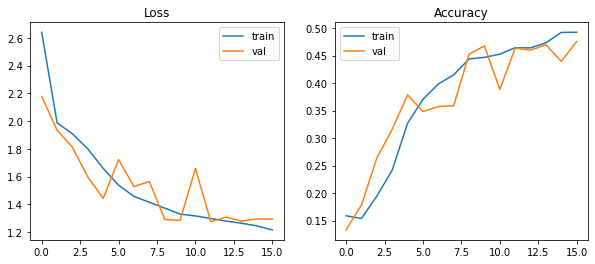

In [35]:
plot_acc_loss(history, 16)

In [36]:
evaluate_model(model, X_train, y_train, CLASSES, "model_train_evaluation")

239/239 [==============================] - 57s 240ms/step - loss: 1.2201 - accuracy: 0.4978
Test loss: 1.2201263904571533
Test accuracy: 0.4978349208831787
[[762 300   3   4   3   3   0]
 [ 91 694 138  26   9   8  10]
 [  1 337 592 174  45  36  31]
 [  2 115 300 399 146  72  38]
 [  3  79 241 286 187 177  99]
 [  4  41 119  84  91 273 460]
 [  0  23  49  16  22 141 887]]
              precision    recall  f1-score   support

           0       0.88      0.71      0.79      1075
           1       0.44      0.71      0.54       976
           2       0.41      0.49      0.45      1216
           3       0.40      0.37      0.39      1072
           4       0.37      0.17      0.24      1072
           5       0.38      0.25      0.31      1072
           6       0.58      0.78      0.67      1138

    accuracy                           0.50      7621
   macro avg       0.50      0.50      0.48      7621
weighted avg       0.50      0.50      0.48      7621



In [37]:
evaluate_model(model, X_test, y_test, CLASSES, "model_test_evaluation")

118/118 [==============================] - 28s 235ms/step - loss: 1.3156 - accuracy: 0.4810
Test loss: 1.315564751625061
Test accuracy: 0.4809587299823761
[[344 172   6   3   0   2   3]
 [ 39 341  74  15   2   6   4]
 [  2 154 285  85  33  21  19]
 [  0  71 136 215  64  27  15]
 [  2  53 119 139  74 101  40]
 [  0  18  64  40  53 132 221]
 [  2  21  29   6  13  75 415]]
              precision    recall  f1-score   support

           0       0.88      0.65      0.75       530
           1       0.41      0.71      0.52       481
           2       0.40      0.48      0.43       599
           3       0.43      0.41      0.42       528
           4       0.31      0.14      0.19       528
           5       0.36      0.25      0.30       528
           6       0.58      0.74      0.65       561

    accuracy                           0.48      3755
   macro avg       0.48      0.48      0.47      3755
weighted avg       0.48      0.48      0.47      3755



In [38]:
model.save('models/model_with_RMSprop')

2022-09-01 20:17:42.867381: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: models/model_with_RMSprop/assets
